# Bayesian Networks and Flight Delay : SFO to PHL

Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Known factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In particular, we will examine delays in flight from San Francisco International Airport (SFO) to Philadelphia International Airport (PHL).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', 'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','DIVERTED','Unnamed: 29'],axis=1)

def dateColumns(df):
    '''
    Given a column with mm/dd/yyyy, create a MONTH and DAY column.
    '''
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]
    
def changeTimetoBinary(df, col):
    '''
    change all times in df[col] to binary variable AM (0) or PM (1)
    '''
    mask = df[col] < 12.0
    df.loc[mask, col] = 0
    mask = df[col] >= 12.0
    df.loc[mask, col] = 1

## The Nitty-Gritty: Preparing the Data

### Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df in intervals of 10
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures'] // 10
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures'] // 10
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals'] // 10
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals'] // 10
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

In [5]:
# change all times to binary variable AM (0) or PM (1)
changeTimetoBinary(flights_df, 'CRS_DEP_TIME')
changeTimetoBinary(flights_df, 'CRS_ARR_TIME')

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [6]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
# save as CSV
flights_df.to_csv('full_data.csv',index=False)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
DEP_DELAY,28.0,90.0,32.0,24.0,-1.0,0.0,-9.0,17.0,2.0,1.0,...,81.0,23.0,-1.0,-6.0,14.0,10.0,-5.0,0.0,35.0,0.0
TAXI_OUT,26.0,12.0,17.0,16.0,29.0,16.0,19.0,24.0,23.0,31.0,...,20.0,29.0,39.0,36.0,45.0,21.0,29.0,27.0,29.0,27.0
TAXI_IN,3.0,5.0,4.0,6.0,4.0,6.0,5.0,3.0,3.0,7.0,...,5.0,6.0,5.0,5.0,8.0,11.0,11.0,7.0,10.0,5.0
CRS_ARR_TIME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
CARRIER_DELAY,0.0,30.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,1.0,...,5.0,20.0,0.0,0.0,14.0,0.0,0.0,0.0,35.0,0.0


### Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [7]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)
# save as CSV
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

## Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise). As we find dependencies, we will also be making sure that we are not creating any accidental cycles.

In [8]:
bn = nx.DiGraph()
flight_edges_df = pd.DataFrame(columns=['from_node', 'to_node'])

In [9]:
def regression_model(from_li, to_node):
    '''
    return OLS regression model, given list from_li of nodes and singular to_node
    '''
    X = train_df[from_li]
    y = train_df[to_node]
    model = sm.OLS(y, X).fit()
    return model

def update_flights_edges_df(from_li, str_var, flight_edges_df):
    '''
    update dataframe of edges using a list of from nodes, the string value of the node,
    and the current dataframe of edges.
    '''
    # update flights_edges_df with from_node to to_node entries
    flights_edges_dict = dict()
    for node in from_li:
        flights_edges_dict[node] = str_var
    temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
    flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
    flight_edges_df = flight_edges_df.drop(['index'], axis=1)

    # create network
    bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
    
    # check to see if there are cycles, print one cycle if there exists at least one
    try:
        print(nx.find_cycle(bn, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
        
    return flight_edges_df, bn

def draw_graph(df,name):
    '''
    takes in dataframe of edges (from_node, to_node) and plots directed graph
    saves to name
    '''
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())

    G_edges = [edge for edge in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
    nx.draw_networkx_labels(G, pos,font_size='10')
    nx.draw_networkx_edges(G, pos, edgelist=G_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
    plt.savefig('./images/'+ name)
    plt.show()
    
def remove_edge(from_edge,to_edge,df):
    '''
    remove from_edge to to_edge directed edge from df
    '''
    # remove edge from df
    df = df[(flight_edges_df.from_node != from_edge) | (flight_edges_df.to_node != to_edge)]
    
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())
    # check for cycles
    try:
        print(nx.find_cycle(G, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
    return df, G

### ARR_DEL15

In [10]:
arr_15_from = ['CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
regression_model(arr_15_from, 'ARR_DEL15').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     173.6
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          2.22e-166
Time:                        03:24:37   Log-Likelihood:                -450.14
No. Observations:                 774   AIC:                             916.3
Df Residuals:                     766   BIC:                             953.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.0897      0.039      2.311      0.021       0.014       0.166
TAXI_OUT                0.0109      0.001      9.157      0.000       0.009       0.013
TAXI_IN                 0.0039      0.002      2.237      0.026       0.000       0.007
CRS_ARR_TIME            0.0502      0.038      1.310      0.191      -0.025       0.125
CARRIER_DELAY           0.0080      0.001     10.653      0.000       0.007       0.009
WEATHER_DELAY           0.0048      0.003      1.839      0.066      -0.000       0.010
SECURITY_DELAY          0.0050      0.008      0.647      0.518      -0.010       0.020
LATE_AIRCRAFT_DELAY     0.0075      0.001     10.696      0.000       0.006       0.009
==============================================================================
Omnibus:                     5025.430   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.581
Skew:                           0.061   Prob(JB):                     1.15e-13
Kurtosis:                       1.646   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No cycle found! You may proceed.


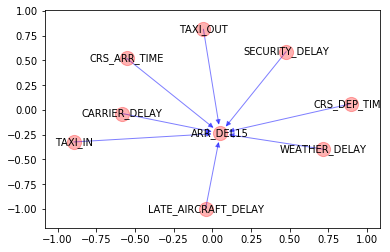

In [11]:
# update dataframe of edges and draw graph
flight_edges_df, bn = update_flights_edges_df(arr_15_from, 'ARR_DEL15',flight_edges_df)
draw_graph(flight_edges_df,'initial_bn.png')

Using regressional analysis, we conclude that ARR_DEL15 is dependent on six factors. So far, we do not have any cycles (remember that a Bayesian network consists of a directed acyclic graph), so we may proceed by moving onto finding more dependencies by choosing an arbitrary parent of ARR_DEL15.

### NAS Delay

Carrier Delay depends on

In [12]:
nas_delay_from =['QUARTER', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CARRIER_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'] 
regression_model(nas_delay_from, 'NAS_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     115.4
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          2.16e-145
Time:                        03:24:37   Log-Likelihood:                -3127.4
No. Observations:                 774   AIC:                             6275.
Df Residuals:                     764   BIC:                             6321.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -3.2183      0.426     -7.554      0.000      -4.055      -2.382
DAY_OF_WEEK            -1.2169      0.225     -5.413      0.000      -1.658      -0.776
CRS_DEP_TIME           -4.8042      0.997     -4.818      0.000      -6.762      -2.847
DEP_DELAY               0.6214      0.029     21.604      0.000       0.565       0.678
TAXI_OUT                0.6329      0.039     16.306      0.000       0.557       0.709
TAXI_IN                 0.7250      0.057     12.804      0.000       0.614       0.836
CARRIER_DELAY          -0.6882      0.039    -17.521      0.000      -0.765      -0.611
WEATHER_DELAY          -0.6024      0.087     -6.888      0.000      -0.774      -0.431
SECURITY_DELAY         -0.7161      0.245     -2.919      0.004      -1.198      -0.234
LATE_AIRCRAFT_DELAY    -0.7160      0.040    -18.008      0.000      -0.794      -0.638
==============================================================================
Omnibus:                      150.582   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              367.091
Skew:                           1.022   Prob(JB):                     1.94e-80
Kurtosis:                       5.685   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
flight_edges_df, bn = update_flights_edges_df(nas_delay_from, 'NAS_DELAY',flight_edges_df)

No cycle found! You may proceed.


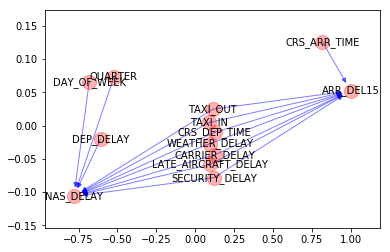

In [14]:
draw_graph(flight_edges_df, 'nas-arr_del15.png')

### Late Aircraft Delay

Now, we took a look at the variables that LATE_AIRCRAFT_DELAY rely on. From this point on, we will not display the graph.

In [15]:
late_aircraft_from = ['QUARTER', 'MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY'] 
regression_model(late_aircraft_from, 'LATE_AIRCRAFT_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.818
Model:                             OLS   Adj. R-squared:                  0.815
Method:                  Least Squares   F-statistic:                     284.7
Date:                 Mon, 09 Apr 2018   Prob (F-statistic):          6.88e-272
Time:                         03:24:38   Log-Likelihood:                -2904.3
No. Observations:                  774   AIC:                             5833.
Df Residuals:                      762   BIC:                             5888.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
QUARTER           -5.1988      1.331     -3.906      0.000      -7.811      -2.586
MONTH              1.4371      0.448      3.206      0.001       0.557       2.317
DAY_OF_WEEK       -0.7032      0.175     -4.015      0.000      -1.047      -0.359
CRS_DEP_TIME      -3.4947      1.078     -3.241      0.001      -5.611      -1.378
DEP_DELAY          0.7011      0.013     52.720      0.000       0.675       0.727
TAXI_OUT           0.3725      0.036     10.271      0.000       0.301       0.444
TAXI_IN            0.4157      0.046      9.085      0.000       0.326       0.505
CRS_ARR_TIME      -3.5598      1.078     -3.302      0.001      -5.676      -1.443
CARRIER_DELAY     -0.7574      0.023    -33.084      0.000      -0.802      -0.712
WEATHER_DELAY     -0.7031      0.063    -11.110      0.000      -0.827      -0.579
NAS_DELAY         -0.4313      0.023    -18.560      0.000      -0.477      -0.386
SECURITY_DELAY    -0.5001      0.184     -2.712      0.007      -0.862      -0.138
==============================================================================
Omnibus:                      159.550   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2597.022
Skew:                          -0.424   Prob(JB):                         0.00
Kurtosis:                      11.934   Cond. No.                         205.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
flight_edges_df, bn = update_flights_edges_df(late_aircraft_from, 'LATE_AIRCRAFT_DELAY',flight_edges_df)

[('NAS_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'NAS_DELAY')]


Since __NAS_DELAY__ and __LATE_AIRCRAFT_DELAY__ have edges pointing to each other, we must decide which edge we are going to get rid of. The FAA (http://aspmhelp.faa.gov/index.php/Types_of_Delay) defines __NAS_DELAY__ as delay that is "within the control of the National Airspace System (NAS)," including "non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc." It goes on to state that delays at the destination airport that occur after Actual Gate Out time are attributed to the NAS (such as gate in delay and taxi in delay). On the other hand, FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. That is, the two seem to have no direct relationship with one another at all. Therefore, we remove both edges.

In [17]:
# remove both edges
flight_edges_df, _ = remove_edge('NAS_DELAY','LATE_AIRCRAFT_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY','NAS_DELAY', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


### Carrier Delay

In [18]:
carrier_delay_from = ['QUARTER', 'MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',] 
regression_model(carrier_delay_from, 'CARRIER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     211.7
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          4.01e-233
Time:                        03:24:38   Log-Likelihood:                -2914.9
No. Observations:                 774   AIC:                             5854.
Df Residuals:                     762   BIC:                             5910.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -4.5085      1.353     -3.333      0.001      -7.164      -1.853
MONTH                   1.2959      0.455      2.848      0.005       0.403       2.189
DAY_OF_WEEK            -0.4542      0.179     -2.542      0.011      -0.805      -0.103
CRS_DEP_TIME           -5.2519      1.084     -4.844      0.000      -7.380      -3.124
DEP_DELAY               0.6918      0.015     47.003      0.000       0.663       0.721
TAXI_OUT                0.3693      0.037     10.014      0.000       0.297       0.442
TAXI_IN                 0.4054      0.047      8.705      0.000       0.314       0.497
CRS_ARR_TIME           -5.0786      1.085     -4.679      0.000      -7.209      -2.948
WEATHER_DELAY          -0.6913      0.064    -10.724      0.000      -0.818      -0.565
NAS_DELAY              -0.4354      0.024    -18.446      0.000      -0.482      -0.389
SECURITY_DELAY         -0.6566      0.186     -3.523      0.000      -1.022      -0.291
LATE_AIRCRAFT_DELAY    -0.7785      0.024    -33.084      0.000      -0.825      -0.732
==============================================================================
Omnibus:                      135.420   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2147.156
Skew:                          -0.201   Prob(JB):                         0.00
Kurtosis:                      11.150   Cond. No.                         210.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
flight_edges_df, bn = update_flights_edges_df(carrier_delay_from, 'CARRIER_DELAY',flight_edges_df)

[('NAS_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'NAS_DELAY')]


__CARRIER_DELAY__ is within the control of the air carrier, such as: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays. This seems to have little to do with __NAS_DELAY__ and vice versa. Thus, we remove both edges

In [20]:
# remove both edges
flight_edges_df, _ = remove_edge('CARRIER_DELAY','NAS_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('NAS_DELAY','CARRIER_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]
[('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY')]


Recall that FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. It would seem probable that a late prior aircraft could cause carrier delay but not the other way around. Thus, we only remove the edge from CARRIER_DELAY to LATE_AIRCRAFT_DELAY.

In [21]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY','LATE_AIRCRAFT_DELAY', flight_edges_df)

No cycle found! You may proceed.


### WEATHER_DELAY

In [22]:
weather_delay_from = ['QUARTER', 'MONTH', 'DAY_OF_WEEK', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'DelayedDepartureSFO', 'DelayedArrivalPHL', 'ScheduledArrivalPHL'] 
regression_model(weather_delay_from, 'WEATHER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          WEATHER_DELAY   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     16.18
Date:                Mon, 09 Apr 2018   Prob (F-statistic):           6.22e-33
Time:                        03:24:38   Log-Likelihood:                -2396.3
No. Observations:                 774   AIC:                             4819.
Df Residuals:                     761   BIC:                             4879.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -1.8062      0.686     -2.634      0.009      -3.152      -0.460
MONTH                   0.5860      0.232      2.531      0.012       0.132       1.040
DAY_OF_WEEK            -0.2569      0.089     -2.875      0.004      -0.432      -0.082
DEP_DELAY               0.1589      0.013     12.140      0.000       0.133       0.185
TAXI_OUT                0.0819      0.018      4.664      0.000       0.047       0.116
TAXI_IN                 0.0775      0.024      3.177      0.002       0.030       0.125
CRS_ARR_TIME           -0.7757      0.394     -1.969      0.049      -1.549      -0.002
CARRIER_DELAY          -0.1717      0.017    -10.064      0.000      -0.205      -0.138
NAS_DELAY              -0.0927      0.013     -6.872      0.000      -0.119      -0.066
LATE_AIRCRAFT_DELAY    -0.1868      0.017    -10.747      0.000      -0.221      -0.153
DelayedDepartureSFO     2.6908      0.753      3.572      0.000       1.212       4.169
DelayedArrivalPHL       7.2264      1.326      5.449      0.000       4.623       9.830
ScheduledArrivalPHL    -1.3020      0.303     -4.304      0.000      -1.896      -0.708
==============================================================================
Omnibus:                     1727.373   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6766409.243
Skew:                          18.700   Prob(JB):                         0.00
Kurtosis:                     459.522   Cond. No.                         361.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Though not ideal in p-value, CRS_DEP_TIME seems like the only likely variable which WEATHER_DELAY may be dependent on.

In [23]:
flight_edges_df, bn = update_flights_edges_df(weather_delay_from, 'WEATHER_DELAY',flight_edges_df)

[('NAS_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'NAS_DELAY')]


In [24]:
flight_edges_df, bn = remove_edge('NAS_DELAY','WEATHER_DELAY', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY')]


In [25]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY','WEATHER_DELAY', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY')]


In [26]:
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY','WEATHER_DELAY', flight_edges_df)

No cycle found! You may proceed.


### Security Delay

In [27]:
security_delay_from = ['DEP_DELAY', 'CARRIER_DELAY'] 
regression_model(security_delay_from, 'SECURITY_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SECURITY_DELAY   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.552
Date:                Mon, 09 Apr 2018   Prob (F-statistic):             0.0108
Time:                        03:24:38   Log-Likelihood:                -1648.9
No. Observations:                 774   AIC:                             3302.
Df Residuals:                     772   BIC:                             3311.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
DEP_DELAY         0.0065      0.002      3.017      0.003       0.002       0.011
CARRIER_DELAY    -0.0081      0.004     -1.877      0.061      -0.017       0.000
==============================================================================
Omnibus:                     2022.804   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18387412.988
Skew:                          27.332   Prob(JB):                         0.00
Kurtosis:                     756.103   Cond. No.                         2.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
flight_edges_df, bn = update_flights_edges_df(security_delay_from, 'SECURITY_DELAY',flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'SECURITY_DELAY'), ('SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY')]


In [29]:
flight_edges_df, bn = remove_edge('SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',flight_edges_df)

[('CARRIER_DELAY', 'SECURITY_DELAY'), ('SECURITY_DELAY', 'CARRIER_DELAY')]


In [30]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY', 'SECURITY_DELAY', flight_edges_df)

No cycle found! You may proceed.


### CRS Arrival Time

In [31]:
crs_arrival_from = ['QUARTER', 'MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY'] 
regression_model(crs_arrival_from, 'CRS_ARR_TIME').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CRS_ARR_TIME   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     298.2
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          1.65e-267
Time:                        03:24:38   Log-Likelihood:                -272.82
No. Observations:                 774   AIC:                             567.6
Df Residuals:                     763   BIC:                             618.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 0.2676      0.044      6.115      0.000       0.182       0.353
MONTH                  -0.0710      0.015     -4.792      0.000      -0.100      -0.042
DAY_OF_WEEK             0.0363      0.006      6.327      0.000       0.025       0.048
CRS_DEP_TIME           -0.7131      0.025    -28.173      0.000      -0.763      -0.663
DEP_DELAY               0.0062      0.001      6.717      0.000       0.004       0.008
TAXI_OUT                0.0165      0.001     14.490      0.000       0.014       0.019
TAXI_IN                 0.0096      0.002      6.150      0.000       0.007       0.013
CARRIER_DELAY          -0.0054      0.001     -4.606      0.000      -0.008      -0.003
WEATHER_DELAY          -0.0049      0.002     -2.183      0.029      -0.009      -0.000
NAS_DELAY              -0.0059      0.001     -6.574      0.000      -0.008      -0.004
LATE_AIRCRAFT_DELAY    -0.0039      0.001     -3.233      0.001      -0.006      -0.002
==============================================================================
Omnibus:                       24.891   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.878
Skew:                           0.198   Prob(JB):                     6.62e-11
Kurtosis:                       4.139   Cond. No.                         192.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
flight_edges_df, bn = update_flights_edges_df(crs_arrival_from, 'CRS_ARR_TIME', flight_edges_df)

[('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'CRS_ARR_TIME')]


In [33]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CRS_ARR_TIME')]


In [34]:
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY', 'CRS_ARR_TIME', flight_edges_df)

[('NAS_DELAY', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'NAS_DELAY')]


In [35]:
flight_edges_df, bn = remove_edge('NAS_DELAY', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_ARR_TIME', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CRS_ARR_TIME')]


In [36]:
flight_edges_df, bn = remove_edge('WEATHER_DELAY', 'CRS_ARR_TIME', flight_edges_df)

No cycle found! You may proceed.


### CRS Departure Time

In [37]:
crs_departure_from = ['QUARTER', 'MONTH', 'DAY_OF_WEEK', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY'] 
regression_model(crs_departure_from, 'CRS_DEP_TIME').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CRS_DEP_TIME   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     200.4
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          6.58e-206
Time:                        03:24:38   Log-Likelihood:                -274.78
No. Observations:                 774   AIC:                             569.6
Df Residuals:                     764   BIC:                             616.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 0.2044      0.044      4.634      0.000       0.118       0.291
MONTH                  -0.0516      0.015     -3.463      0.001      -0.081      -0.022
DAY_OF_WEEK             0.0351      0.006      6.128      0.000       0.024       0.046
DEP_DELAY               0.0058      0.001      6.916      0.000       0.004       0.007
TAXI_OUT                0.0164      0.001     14.595      0.000       0.014       0.019
TAXI_IN                 0.0085      0.002      5.425      0.000       0.005       0.012
CRS_ARR_TIME           -0.7129      0.025    -28.129      0.000      -0.763      -0.663
CARRIER_DELAY          -0.0049      0.001     -4.497      0.000      -0.007      -0.003
NAS_DELAY              -0.0069      0.001     -7.949      0.000      -0.009      -0.005
LATE_AIRCRAFT_DELAY    -0.0031      0.001     -2.806      0.005      -0.005      -0.001
==============================================================================
Omnibus:                       55.642   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.620
Skew:                           0.529   Prob(JB):                     5.71e-20
Kurtosis:                       4.276   Cond. No.                         194.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
flight_edges_df, bn = update_flights_edges_df(crs_departure_from, 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'NAS_DELAY'), ('NAS_DELAY', 'CRS_DEP_TIME')]


In [39]:
flight_edges_df, bn = remove_edge('NAS_DELAY', 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'CRS_DEP_TIME')]


In [40]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY', 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CRS_DEP_TIME')]


In [41]:
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY', 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'CRS_DEP_TIME')]


In [42]:
flight_edges_df, bn = remove_edge('CRS_DEP_TIME', 'CRS_ARR_TIME', flight_edges_df)

No cycle found! You may proceed.


### Taxi Out

Taxi Out Time, in Minutes.

In [43]:
taxi_out_from = ['QUARTER', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
regression_model(taxi_out_from, 'TAXI_OUT').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     611.1
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        03:24:38   Log-Likelihood:                -2854.6
No. Observations:                 774   AIC:                             5731.
Df Residuals:                     763   BIC:                             5782.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 3.8155      0.286     13.354      0.000       3.255       4.376
DAY_OF_WEEK             0.8351      0.163      5.127      0.000       0.515       1.155
CRS_DEP_TIME           13.4406      0.885     15.187      0.000      11.703      15.178
DEP_DELAY              -0.3262      0.024    -13.656      0.000      -0.373      -0.279
TAXI_IN                -0.2888      0.044     -6.583      0.000      -0.375      -0.203
CRS_ARR_TIME           13.3767      0.878     15.239      0.000      11.654      15.100
CARRIER_DELAY           0.3105      0.031      9.904      0.000       0.249       0.372
WEATHER_DELAY           0.2723      0.063      4.328      0.000       0.149       0.396
NAS_DELAY               0.3975      0.022     18.126      0.000       0.354       0.441
SECURITY_DELAY          0.3914      0.173      2.262      0.024       0.052       0.731
LATE_AIRCRAFT_DELAY     0.3214      0.032     10.154      0.000       0.259       0.384
==============================================================================
Omnibus:                       15.247   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.045
Skew:                           0.236   Prob(JB):                     7.32e-05
Kurtosis:                       3.607   Cond. No.                         162.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
flight_edges_df, bn = update_flights_edges_df(taxi_out_from,'TAXI_OUT',flight_edges_df)

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY')]


In [45]:
flight_edges_df, bn = remove_edge('NAS_DELAY', 'TAXI_OUT', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'LATE_AIRCRAFT_DELAY')]


In [46]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CARRIER_DELAY')]


In [47]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CARRIER_DELAY', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY')]


In [48]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'WEATHER_DELAY', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [49]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CRS_DEP_TIME')]


In [50]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CRS_DEP_TIME', flight_edges_df)

No cycle found! You may proceed.


### Taxi In

In [51]:
taxi_in_from = ['QUARTER', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY'] 
regression_model(taxi_in_from, 'TAXI_IN').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TAXI_IN   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     99.98
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          1.50e-131
Time:                        03:24:38   Log-Likelihood:                -2685.2
No. Observations:                 774   AIC:                             5390.
Df Residuals:                     764   BIC:                             5437.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 1.5309      0.249      6.155      0.000       1.043       2.019
DAY_OF_WEEK             0.4667      0.132      3.545      0.000       0.208       0.725
CRS_DEP_TIME            4.5675      0.793      5.762      0.000       3.011       6.124
DEP_DELAY              -0.1988      0.020     -9.991      0.000      -0.238      -0.160
TAXI_OUT               -0.1837      0.028     -6.513      0.000      -0.239      -0.128
CRS_ARR_TIME            5.0782      0.783      6.482      0.000       3.540       6.616
CARRIER_DELAY           0.2166      0.025      8.552      0.000       0.167       0.266
WEATHER_DELAY           0.1902      0.051      3.761      0.000       0.091       0.290
NAS_DELAY               0.2610      0.019     13.966      0.000       0.224       0.298
LATE_AIRCRAFT_DELAY     0.2291      0.026      8.938      0.000       0.179       0.279
==============================================================================
Omnibus:                     1102.700   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           441216.467
Skew:                           7.547   Prob(JB):                         0.00
Kurtosis:                     118.988   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
flight_edges_df, bn = update_flights_edges_df(taxi_in_from,'TAXI_IN',flight_edges_df)

[('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [53]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'NAS_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY')]


In [54]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY')]


In [55]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'NAS_DELAY', flight_edges_df)

[('TAXI_IN', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'TAXI_IN')]


In [56]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'CARRIER_DELAY', flight_edges_df)

[('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'NAS_DELAY')]


In [57]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'WEATHER_DELAY', flight_edges_df)

[('TAXI_IN', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'TAXI_IN')]


In [58]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'NAS_DELAY'), ('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'CRS_DEP_TIME')]


In [59]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'CRS_DEP_TIME', flight_edges_df)

[('TAXI_IN', 'TAXI_OUT'), ('TAXI_OUT', 'TAXI_IN')]


In [60]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'TAXI_OUT', flight_edges_df)

No cycle found! You may proceed.


### Calendar Quarter

We come to a rather interesting (not entirely unlikely) conclusion that CRS_DEP_TIME and CRS_ARR_TIME may directly influence QUARTER.

In [61]:
quarter_from = ['MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY'] 
regression_model(quarter_from, 'QUARTER').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                QUARTER   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     7328.
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        03:24:38   Log-Likelihood:                -107.60
No. Observations:                 774   AIC:                             237.2
Df Residuals:                     763   BIC:                             288.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
MONTH                   0.3248      0.003    106.055      0.000       0.319       0.331
DAY_OF_WEEK             0.0119      0.005      2.515      0.012       0.003       0.021
CRS_DEP_TIME            0.1293      0.029      4.487      0.000       0.073       0.186
DEP_DELAY               0.0034      0.001      4.533      0.000       0.002       0.005
TAXI_OUT                0.0048      0.001      4.690      0.000       0.003       0.007
TAXI_IN                 0.0035      0.001      2.688      0.007       0.001       0.006
CRS_ARR_TIME            0.1746      0.029      6.115      0.000       0.119       0.231
CARRIER_DELAY          -0.0033      0.001     -3.466      0.001      -0.005      -0.001
WEATHER_DELAY          -0.0044      0.002     -2.402      0.017      -0.008      -0.001
NAS_DELAY              -0.0017      0.001     -2.283      0.023      -0.003      -0.000
LATE_AIRCRAFT_DELAY    -0.0039      0.001     -4.009      0.000      -0.006      -0.002
==============================================================================
Omnibus:                     1446.705   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.313
Skew:                           0.088   Prob(JB):                     9.75e-13
Kurtosis:                       1.702   Cond. No.                         194.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
flight_edges_df, bn = update_flights_edges_df(quarter_from, 'QUARTER',flight_edges_df)

[('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'QUARTER'), ('QUARTER', 'NAS_DELAY')]


In [63]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'QUARTER', flight_edges_df)

[('NAS_DELAY', 'QUARTER'), ('QUARTER', 'NAS_DELAY')]


In [64]:
flight_edges_df, bn = remove_edge('NAS_DELAY', 'QUARTER', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'QUARTER'), ('QUARTER', 'LATE_AIRCRAFT_DELAY')]


In [65]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'QUARTER', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'QUARTER'), ('QUARTER', 'LATE_AIRCRAFT_DELAY')]


In [66]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY', 'QUARTER', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'QUARTER'), ('QUARTER', 'LATE_AIRCRAFT_DELAY')]


In [67]:
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY', 'QUARTER', flight_edges_df)

[('QUARTER', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'QUARTER')]


In [68]:
flight_edges_df, bn = remove_edge('WEATHER_DELAY', 'QUARTER', flight_edges_df)

[('CRS_DEP_TIME', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'CRS_DEP_TIME')]


In [69]:
flight_edges_df, bn = remove_edge('CRS_DEP_TIME', 'QUARTER', flight_edges_df)

[('CRS_ARR_TIME', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME')]


In [70]:
flight_edges_df, bn = remove_edge('CRS_ARR_TIME', 'QUARTER', flight_edges_df)

No cycle found! You may proceed.


### Departure Delay

This is the difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

Departure time is the time recorded when the plane's parking brakes are released, which is after doors are closed and just prior to the plane beginning to taxi. That is, departure time starts right before a plan leaves its gate. Therefore, while it is likely that a difference in CRS departure time and actual departure time causes an NAS delay, it is impossible for NAS delay to influence the departure time difference. Thus, we remove the edge from NAS_DELAY to DEP_DELAY.

In [71]:
departure_delay_from = ['QUARTER', 'MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'] 
regression_model(departure_delay_from, 'DEP_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     653.5
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        03:24:38   Log-Likelihood:                -3085.4
No. Observations:                 774   AIC:                             6195.
Df Residuals:                     762   BIC:                             6251.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 7.3199      1.678      4.363      0.000       4.027      10.613
MONTH                  -2.0220      0.565     -3.576      0.000      -3.132      -0.912
DAY_OF_WEEK             0.9880      0.221      4.476      0.000       0.555       1.421
CRS_DEP_TIME            9.3315      1.330      7.018      0.000       6.721      11.942
TAXI_OUT               -0.6021      0.044    -13.759      0.000      -0.688      -0.516
TAXI_IN                -0.5787      0.057    -10.127      0.000      -0.691      -0.466
CRS_ARR_TIME            9.0269      1.333      6.774      0.000       6.411      11.643
CARRIER_DELAY           1.0747      0.023     47.003      0.000       1.030       1.120
WEATHER_DELAY           0.9849      0.078     12.551      0.000       0.831       1.139
NAS_DELAY               0.6237      0.027     22.906      0.000       0.570       0.677
SECURITY_DELAY          0.9273      0.232      4.002      0.000       0.472       1.382
LATE_AIRCRAFT_DELAY     1.1195      0.021     52.720      0.000       1.078       1.161
==============================================================================
Omnibus:                      299.754   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3035.994
Skew:                           1.453   Prob(JB):                         0.00
Kurtosis:                      12.257   Cond. No.                         151.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
flight_edges_df, bn = update_flights_edges_df(departure_delay_from,'DEP_DELAY',flight_edges_df)

[('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [73]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'NAS_DELAY', flight_edges_df)

[('TAXI_IN', 'DEP_DELAY'), ('DEP_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'TAXI_IN')]


In [74]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'DEP_DELAY', flight_edges_df)

[('DEP_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY')]


In [75]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('DEP_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY')]


In [76]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'CARRIER_DELAY', flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'NAS_DELAY')]


In [77]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'WEATHER_DELAY', flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'SECURITY_DELAY'), ('SECURITY_DELAY', 'NAS_DELAY')]


In [78]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'SECURITY_DELAY', flight_edges_df)

[('DEP_DELAY', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY')]


In [79]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'NAS_DELAY'), ('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'CRS_DEP_TIME')]


In [80]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'CRS_DEP_TIME', flight_edges_df)

[('DEP_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY')]


In [81]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'DEP_DELAY', flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'QUARTER'), ('QUARTER', 'NAS_DELAY')]


In [82]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'QUARTER', flight_edges_df)

No cycle found! You may proceed.


### DelayedDepartureSFO

In [83]:
delayed_SFO_from = ['TAXI_OUT', 'TAXI_IN', 'WEATHER_DELAY', 'ScheduledDepartureSFO', 'ScheduledArrivalPHL']
regression_model(delayed_SFO_from, 'DelayedDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     DelayedDepartureSFO   R-squared:                       0.277
Model:                             OLS   Adj. R-squared:                  0.272
Method:                  Least Squares   F-statistic:                     58.93
Date:                 Mon, 09 Apr 2018   Prob (F-statistic):           5.72e-52
Time:                         03:24:38   Log-Likelihood:                 23.428
No. Observations:                  774   AIC:                            -36.86
Df Residuals:                      769   BIC:                            -13.60
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
TAXI_OUT                 -0.0005      0.000     -1.208      0.227      -0.001       0.000
TAXI_IN                   0.0016      0.001      1.729      0.084      -0.000       0.003
WEATHER_DELAY             0.0044      0.001      3.131      0.002       0.002       0.007
ScheduledDepartureSFO     0.0740      0.006     12.704      0.000       0.063       0.085
ScheduledArrivalPHL       0.0211      0.009      2.352      0.019       0.003       0.039
==============================================================================
Omnibus:                      331.683   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1290.879
Skew:                           2.047   Prob(JB):                    4.89e-281
Kurtosis:                       7.824   Cond. No.                         34.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
flight_edges_df, bn = update_flights_edges_df(delayed_SFO_from,'DelayedDepartureSFO',flight_edges_df)

[('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'NAS_DELAY')]


In [85]:
flight_edges_df, bn = remove_edge('DelayedDepartureSFO', 'WEATHER_DELAY', flight_edges_df)

No cycle found! You may proceed.


###   DelayedArrivalPHL

In [86]:
delayed_PHL_from = ['TAXI_OUT', 'WEATHER_DELAY', 'ScheduledDepartureSFO', 'ScheduledArrivalPHL'] 
regression_model(delayed_PHL_from, 'DelayedArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DelayedArrivalPHL   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     279.2
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          3.21e-148
Time:                        03:24:38   Log-Likelihood:                 404.94
No. Observations:                 774   AIC:                            -801.9
Df Residuals:                     770   BIC:                            -783.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
TAXI_OUT                 -0.0011      0.000     -5.452      0.000      -0.002      -0.001
WEATHER_DELAY             0.0051      0.001      5.986      0.000       0.003       0.007
ScheduledDepartureSFO    -0.0116      0.004     -3.277      0.001      -0.019      -0.005
ScheduledArrivalPHL       0.1714      0.005     31.284      0.000       0.161       0.182
==============================================================================
Omnibus:                      216.764   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1679.280
Skew:                           1.040   Prob(JB):                         0.00
Kurtosis:                       9.909   Cond. No.                         32.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
flight_edges_df, bn = update_flights_edges_df(delayed_PHL_from,'DelayedArrivalPHL',flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'NAS_DELAY')]


In [88]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL', 'WEATHER_DELAY', flight_edges_df)

No cycle found! You may proceed.


### Number of Scheduled Departures from SFO When Delayed Flight is scheduled to Depart

In [89]:
scheduled_SFO_from = ['MONTH', 'CRS_ARR_TIME', 'DelayedDepartureSFO', 'DelayedArrivalPHL', 'ScheduledArrivalPHL'] 
regression_model(scheduled_SFO_from, 'ScheduledDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ScheduledDepartureSFO   R-squared:                       0.430
Model:                               OLS   Adj. R-squared:                  0.427
Method:                    Least Squares   F-statistic:                     116.2
Date:                   Mon, 09 Apr 2018   Prob (F-statistic):           1.61e-91
Time:                           03:24:38   Log-Likelihood:                -1307.6
No. Observations:                    774   AIC:                             2625.
Df Residuals:                        769   BIC:                             2648.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
MONTH                   0.0576      0.009      6.171      0.000       0.039       0.076
CRS_ARR_TIME            0.1115      0.086      1.301      0.194      -0.057       0.280
DelayedDepartureSFO     2.3179      0.181     12.784      0.000       1.962       2.674
DelayedArrivalPHL      -0.9877      0.317     -3.112      0.002      -1.611      -0.365
ScheduledArrivalPHL     0.4502      0.072      6.219      0.000       0.308       0.592
==============================================================================
Omnibus:                      216.271   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              430.464
Skew:                           1.641   Prob(JB):                     3.36e-94
Kurtosis:                       4.605   Cond. No.                         52.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
flight_edges_df, bn = update_flights_edges_df(scheduled_SFO_from,'ScheduledDepartureSFO',flight_edges_df)

[('DelayedDepartureSFO', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'DelayedDepartureSFO')]


In [91]:
flight_edges_df, bn = remove_edge('DelayedDepartureSFO', 'ScheduledDepartureSFO', flight_edges_df)

[('DelayedArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'DelayedArrivalPHL')]


In [92]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL', 'ScheduledDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


### Number of Scheduled Arrivals at PHL When Delayed Flight is scheduled to Depart

In [93]:
scheduled_PHL_from = ['QUARTER', 'TAXI_OUT', 'WEATHER_DELAY', 'DelayedDepartureSFO', 'ScheduledDepartureSFO', 'DelayedArrivalPHL']
regression_model(scheduled_PHL_from, 'ScheduledArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ScheduledArrivalPHL   R-squared:                       0.676
Model:                             OLS   Adj. R-squared:                  0.674
Method:                  Least Squares   F-statistic:                     267.1
Date:                 Mon, 09 Apr 2018   Prob (F-statistic):          3.65e-184
Time:                         03:24:38   Log-Likelihood:                -731.87
No. Observations:                  774   AIC:                             1476.
Df Residuals:                      768   BIC:                             1504.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
QUARTER                   0.0349      0.018      1.989      0.047       0.000       0.069
TAXI_OUT                  0.0057      0.002      3.470      0.001       0.002       0.009
WEATHER_DELAY            -0.0168      0.004     -4.423      0.000      -0.024      -0.009
DelayedDepartureSFO       0.1734      0.095      1.818      0.070      -0.014       0.361
ScheduledDepartureSFO     0.0987      0.017      5.865      0.000       0.066       0.132
DelayedArrivalPHL         3.2303      0.105     30.798      0.000       3.024       3.436
==============================================================================
Omnibus:                       84.981   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.163
Skew:                           0.605   Prob(JB):                     7.65e-45
Kurtosis:                       5.199   Cond. No.                         143.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
flight_edges_df, bn = update_flights_edges_df(scheduled_PHL_from,'ScheduledArrivalPHL',flight_edges_df)

[('NAS_DELAY', 'TAXI_IN'), ('TAXI_IN', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'NAS_DELAY')]


In [95]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'DelayedDepartureSFO', flight_edges_df)

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'NAS_DELAY')]


In [96]:
flight_edges_df, bn = remove_edge('ScheduledArrivalPHL', 'WEATHER_DELAY', flight_edges_df)

[('DelayedDepartureSFO', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'DelayedDepartureSFO')]


In [97]:
flight_edges_df, bn = remove_edge('DelayedDepartureSFO', 'ScheduledArrivalPHL', flight_edges_df)

[('DelayedArrivalPHL', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'DelayedArrivalPHL')]


In [98]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL', 'ScheduledArrivalPHL', flight_edges_df)

[('ScheduledArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'ScheduledArrivalPHL')]


In [99]:
flight_edges_df, bn = remove_edge('ScheduledArrivalPHL', 'ScheduledDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


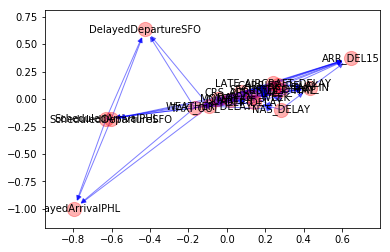

In [100]:
draw_graph(flight_edges_df,'final_bn.png')

In [101]:
print('This graph is a DAG :', nx.is_directed_acyclic_graph(bn),'\nThis edge is a tree :', nx.is_tree(bn))

This graph is a DAG : True 
This edge is a tree : False


In [102]:
# nodes
nodes_li = list(set(list(flight_edges_df['from_node'])+list(flight_edges_df['to_node'])))
nodes_df = pd.DataFrame(nodes_li)
nodes_df.columns = ['nodes']
flight_edges_df.columns=['Source','Target']
# save as csv
flight_edges_df.to_csv('edges.csv',index=False)
nodes_df.to_csv('nodes.csv',index=False)
# numbers to print
print('There are', nodes_df.shape[0], 'nodes and', flight_edges_df.shape[0], 'edges in this graph.')

There are 18 nodes and 83 edges in this graph.
